matrixProfile.stomp(ts, m)  : 時系列tsのmatrix profileを計算(部分時系列の長さはm) <br>
calcMPdistvec(query, ts, m) : 短い時系列queryと長い時系列tsのMPdistベクトルを計算(MPdistの部分時系列の長さはm)


In [1]:
%matplotlib inline

import glob
from IPython.display import clear_output
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

from collections import deque
from matrixprofile import *
from scipy.stats import zscore

plt.rcParams['font.family'] = 'IPAPGothic'

In [31]:
%%time
S, frac, ind = Snippets(a, 200, 5, 70)

done
CPU times: user 1min 35s, sys: 49 ms, total: 1min 35s
Wall time: 1min 35s


In [4]:
def Snippets(ts, m, k, m2):
    n = len(ts)
    
    # MPdistベクトル集合の作成
    lst = list()
    for i in range(n//m):
        clear_output(wait=True)
        print('make MPdistvector[%d / %d]' % (i+1, n//m))
        lst.append(calcMPdistvec(query=ts[m*i:m*(i+1)], ts=ts, m=m2))
    D = np.asarray(lst)
    
    

    # 変数の初期化
    Q = np.ones(D.shape[1]) * np.inf
    C = list()
    C_idx = list()
    snippetProfiles = list()
    
    while True:
        minimumArea = np.inf
        idx = 0
        for i in range(n//m):
            ProfileArea = sum(np.min(np.vstack([D[i], Q]), axis=0))
            if minimumArea > ProfileArea:
                minimumArea = ProfileArea
                idx = i

        Q = np.min(np.vstack([D[idx], Q]), axis=0)
        C.append(ts[m*idx:m*(idx+1)])
        C_idx.append(idx)
        snippetProfiles.append(D[idx])
        
        if len(C) == k: 
            break
    
    C = np.array(C)
    C_idx = np.array(C_idx)
    snippetProfiles = np.asarray(snippetProfiles)
    
    totalmin = np.min(snippetProfiles, axis=0)
    C_frac = np.zeros_like(C_idx, dtype='float')
    for i in range(k):
        f = sum(snippetProfiles[i] == totalmin)
        print(f / (n-m+1))
        C_frac[i] = f / (n-m+1)
        
    clear_output(wait=True)
    print('done')
    
    return C, C_frac, C_idx

### MPdist関連のメソッド

In [5]:
def MPdist(tsA, tsB, m):
    mp = np.concatenate([matrixProfile.stmp(tsA = tsA, tsB = tsB, m = m)[0], matrixProfile.stmp(tsA = tsB, tsB = tsA, m = m)[0]])
#     plt.plot(mp)
    return np.sort(mp)[min(int((len(tsA)+len(tsB))*0.05), len(mp)-1)] 



#*********************************#
#    以下MPdistベクトルのコード   #
#*********************************#

#dequeを更新
def update_deq(deq, val, ind):
    # 先端を削除するべきか判定・処理
    if deq[0][1] == ind - deq.maxlen:
        deq.popleft()
    # 要素を追加
    while(len(deq) != 0):
        if val <= deq[len(deq)-1][0]:
            deq.pop()
        else: 
            break
    deq.append((val,ind))
#     add_deq(deq, val, ind)

#dequeに要素を追加
def add_deq(deq, val, ind):
    while(len(deq) != 0):
        if val <= deq[len(deq)-1][0]:
            deq.pop()
        else: 
            break
    deq.append((val,ind))

#distance profileの集合からMPdistベクトルを計算
def calcMPdistvec_by_DistanceProfile(DPs, k):
    
    row_num, col_num = DPs.shape 
    MatrixProfile_BA = np.min(np.asarray(DPs), axis=0)
    MPdistvec = np.zeros(col_num - row_num + 1)
    deques = list()
    for row in range(row_num):
        deques.append(deque(maxlen=row_num))
        for col in range(row_num-1):
            add_deq(deques[row], DPs[row][col], col)
    
    start = time.time()
    temp_profile_AB = np.zeros(row_num, dtype='float64')
    for col in range(col_num - row_num + 1):        
        for row in range(row_num):

            update_deq(deques[row], DPs[row][col + (row_num-1)], col + (row_num-1))
            temp_profile_AB[row] = deques[row][0][0]
        #ソートしてthrでぶちこむ
#         MPdistvec[col] = MPdist(np.concatenate([temp_profile_AB, MatrixProfile_BA[col:col + row_num]]), k)
        mp = np.sort(np.concatenate([temp_profile_AB, MatrixProfile_BA[col:col + row_num]]))
        MPdistvec[col] = mp[min(k,len(mp)-1)]
#     print("slidemin_time = ", time.time()-start)
    return MPdistvec

# MPdistvecを計算
# query:クエリ時系列
# ts:時系列
# m:MPdictのパラメータ(部分時系列長)
def calcMPdistvec(query, ts, m):
    disP = []
    for i in range(len(query)-m+1):
        disP.append(matrixProfile.distanceProfile.massDistanceProfile(query,i,m,ts)[0])
    disP = np.asarray(disP)
    return calcMPdistvec_by_DistanceProfile(disP, k=int((len(query)-m+1)* 0.05))

Matrix Profileが最小値を取るペアを発見する

In [6]:
def find_minimum_pair(MatP, MatPind):
    minpair = np.unique(np.union1d(np.where(MatP == MatP.min()), MatPind[np.where(MatP == MatP.min())]))
    minpair = minpair.astype('int')
    return minpair

In [7]:
# MPdistVecの実行時間を確認
# tm = list()
# for i in range(5000,100001,5000):
#     print("time series length = ", i)
#     start = time.time()
#     MPdistvect = calcMPdistvec(a[500:700],a[:i],60)
#     tm.append(time.time()-start)
#     print("total time = ", tm[len(tm)-1]) 
#     print()

## 人工データ

### Matrix Profileの実験

ランダムウォークデータにsin波を2つつけた時系列でMatrix Profileを適用する

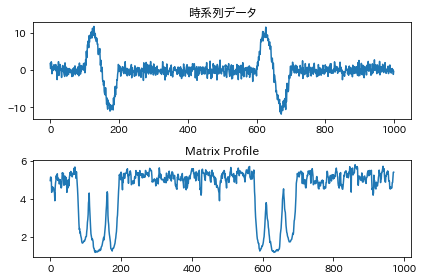

In [8]:
np.random.seed(0)
# trace = np.asarray(pd.read_csv('../Datasets/UCR_TS_Archive_2015/Trace/Trace_TRAIN'))
# t = np.concatenate((trace[2][100:200],trace[12][100:300])

t = np.random.randn(1000)
# t = np.cumsum(t)
t[100:200] += 10*np.sin(np.linspace(0,2*np.pi,100))
t[600:700] += 10*np.sin(np.linspace(0,2*np.pi,100))

plt.subplot(2, 1, 1)
plt.plot(t)
plt.title('時系列データ')

plt.subplot(2, 1, 2)
mpt, mptindex = matrixProfile.stomp(t,30)
plt.plot(mpt)
plt.title('Matrix Profile')

plt.tight_layout()
plt.show()

sin波の部分だけ小さくなっていることが分かる

## UCR Time Series Dataset

In [9]:
# df = pd.read_csv(path,header=None)
# correct_labels = np.asarray(df[0]) #正解ラベル
# df = np.asarray(df.drop(0,axis=1)) #ラベルを削除

HandOut = np.asarray(pd.read_csv('../Datasets/UCR_TS_Archive_2015/StarLightCurves/StarLightCurves_TRAIN'))
label, HandOut = HandOut[:,0], HandOut[:,1:]
# plt.plot(HandOut.T)
# plt.show()

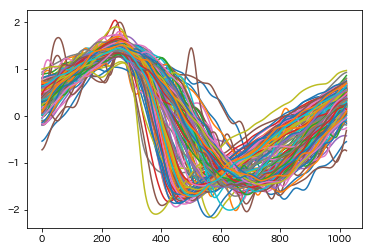

In [10]:
plt.plot(HandOut[label==1].T)
plt.show()

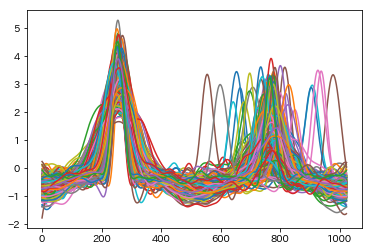

In [11]:
plt.plot(HandOut[label==2].T)
plt.show()

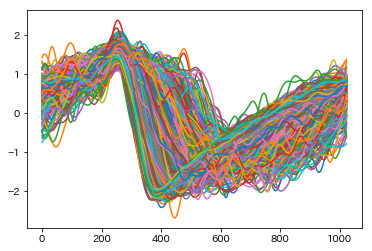

In [12]:
plt.plot(HandOut[label==3].T)
plt.show()

## 線虫

In [29]:
m = 60 # MatrixProfileの部分時系列の長さ
topN = 10000 # 線虫の頭何個使うか

データ呼び出し

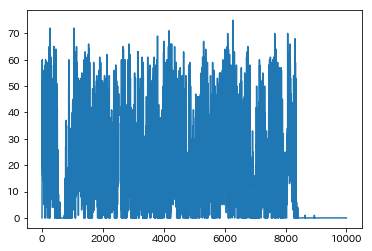

In [30]:
filenames1 = glob.glob("../Datasets/worm1/*f4")
filenames1.sort()
np.random.seed(0)
a = np.fromfile(filenames1[53],'f4')[:topN] + np.abs(10e-4*np.random.randn(topN))
a_nonoise = np.fromfile(filenames1[53],'f4')[:topN]
plt.plot(a)
plt.show()

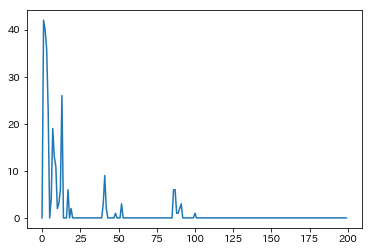

In [16]:
plt.plot(a[500:700])

In [336]:
%%time
MPdistvect = calcMPdistvec(a[500:700],a,60)

CPU times: user 1.06 s, sys: 1 ms, total: 1.06 s
Wall time: 1.06 s


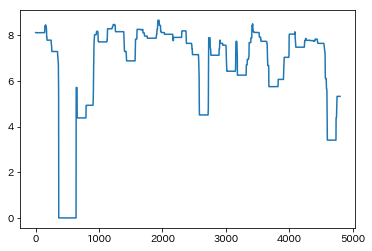

In [337]:
plt.plot(MPdistvect)

In [339]:
%%time
S, frac, ind = Snippets(a, 200, 3, 70)

0.5730056238283691
0.2959800041657988
0.13101437200583213
CPU times: user 24.5 s, sys: 23 ms, total: 24.6 s
Wall time: 24.6 s


In [11]:
# a[3300:3500] += 30 * np.sin(np.linspace(0,2*np.pi,200))
# a[4500:4700] += 30 * np.sin(np.linspace(0,2*np.pi,200))
# a[5300:5500] += 30 * np.sin(np.linspace(0,2*np.pi,200))

In [20]:
MP, MPind = matrixProfile.stomp(a[:1000],m)
MPind = MPind.astype('int')

0の数に対するAV

In [ ]:
AV_zero = np.zeros_like(MP)

for i,_ in enumerate(AV_zero):
    AV_zero[i] = np.sum(a_nonoise[i:i+m]==0)

AV_zero -= min(AV_zero)
AV_zero /= max(AV_zero)

AV_zero = 1 - AV_zero

MP_zero = MP + (1-AV_zero) * MP.max()

plt.subplot(2,1,1)
plt.plot(MP)
plt.title("original")

plt.subplot(2,1,2)
plt.plot(MP_zero)
plt.title("Annotated")

plt.tight_layout()
plt.show()

複雑さに対する　AV

In [ ]:
AV_comp = np.zeros_like(MP)

for i,_ in enumerate(AV_comp):
    AV_comp[i] = np.sqrt(np.sum(np.diff(zscore(a[i:i+m]))**2))
    
AV_comp -= min(AV_comp)
AV_comp /= max(AV_comp)

MP_comp = MP + (1-AV_comp) * MP.max()

plt.subplot(2,1,1)
plt.plot(MP)
plt.title("original")

plt.subplot(2,1,2)
plt.plot(MP_comp)
plt.title("Annotated")

plt.tight_layout()
plt.show()

合成

In [ ]:
AV_sum = AV_zero + AV_comp
AV_sum -= min(AV_sum)
AV_sum /= max(AV_sum)

MP_sum = MP + (1-AV_sum) * MP.max()

plt.subplot(2,1,1)
plt.plot(MP)
plt.title("original")

plt.subplot(2,1,2)
plt.plot(MP_sum)
plt.title("Annotated")

plt.tight_layout()
plt.show()

# 以下特に意味ないコード

In [ ]:
plt.plot(a)

In [ ]:
mindex = find_minimum_pair(MP_sum,MPind)
plt.plot(zscore(a[mindex[0]:mindex[0]+m]))
plt.plot(zscore(a[mindex[1]:mindex[1]+m]))
plt.show()

In [ ]:
find_minimum_pair(MP_comp,MPind)
plt.plot(zscore(a[mindex[0]:mindex[0]+m]))
plt.plot(zscore(a[mindex[1]:mindex[1]+m]))
plt.show()

In [ ]:
find_minimum_pair(MP,MPind)
plt.plot(zscore(a[mindex[0]:mindex[0]+m]))
plt.plot(zscore(a[mindex[1]:mindex[1]+m]))
plt.show()

In [ ]:
plt.plot(MP)
plt.show()

In [ ]:
mindex = find_minimum_pair(MP_sum,MPind)
plt.plot(zscore(a[mindex[0]:mindex[0]+m]))
plt.plot(zscore(a[mindex[1]:mindex[1]+m]))
plt.show()

In [ ]:
plt.plot((a[mindex[0]-50:mindex[0]+m+50]))
# plt.plot((a[mindex[1]:mindex[1]+m]))

In [ ]:
mindex = find_minimum_pair(MP_zero, MPind)
plt.plot(zscore(a[mindex[0]:mindex[0]+m]))
plt.plot(zscore(a[mindex[1]:mindex[1]+m]))
plt.show()

In [ ]:
a[mindex[0]:mindex[0]+m]

In [ ]:
focus = np.array([502,795,2729,4753])
focus_pair = MPind[focus]
for i, (f, fp) in enumerate(zip(focus,focus_pair)):
    plt.subplot(2,2,i+1)
    plt.plot(zscore(a[f:f+m]))
    plt.plot(zscore(a[fp:fp+m]))
plt.show()


print('f  = ', focus)
print('fp = ', focus_pair)
print('dist = ', MP[focus])

In [ ]:
mindex = find_minimum_pair(MP,MPind)

In [ ]:
mindex

In [ ]:
np.linalg.norm(zscore(a[mindex[0]:mindex[0]+m]) - zscore(a[mindex[1]:mindex[1]+m]))

In [ ]:
plt.plot(zscore(a[mindex[0]:mindex[0]+m]))
plt.plot(zscore(a[mindex[1]:mindex[1]+m]))
plt.show()

In [ ]:
plt.plot(a[3059:3259])

In [ ]:
plt.plot(AV_comp[3059:3259])
plt.show()

In [ ]:
plt.plot(MP)
plt.show()

In [ ]:
plt.plot(a[2483:2683])